**Aim**: investigate and visualize the connections between drugs and genes using a knowledge graph constructed from datasets of the CRISPRi + drug screen experiments.

- https://github.com/abearab/DDRi/issues/3

___

Similar works:

- https://github.com/AstraZeneca/skywalkR-graph-features

- https://www.science.org/doi/full/10.1126/sciadv.adj1424

- [KR4SL: knowledge graph reasoning for explainable prediction of synthetic lethality](https://doi.org/10.1093/bioinformatics/btad261)

- https://github.com/mims-harvard/PrimeKG#dataloader-therapeutics-data-commons

- https://tdcommons.ai/multi_pred_tasks/ppi/

Relevant resources:
- https://github.com/cytoscape/py2cytoscape

___

List drug names:
- PARP INHIBITOR
    - Olaparib
- ATM INHIBITOR
    - AZD0156
- ATR INHIBITOR
    - AZD6738
- WEE1 INHIBITOR
    - AZD1775
- DNA-PK INHIBITOR
    - AZD7648

In [ ]:
drug_names = {
    'Pi': 'PARPi',
    'Ri': 'ATRi',
    'Wi': 'WEE1i',
    'Mi': 'ATMi',
    'Ki': 'DNAPKi',
    'PiRi': 'PARPi+ATRi',
    'PiWi': 'PARPi+WEE1i',
    'PiMi': 'PARPi+ATMi',
    'PiKi': 'PARPi+DNAPKi'
}


In [ ]:
import numpy as np 
import pandas as pd
import anndata as ad
import screenpro as scp

from screenpro.load import loadScreenProcessingData

In [ ]:
# import sys
# sys.path.append("/data_gilbert/home/aarab/FunGI")
# from search import *

In [ ]:
# from tdc.multi_pred import PPI
# data = PPI(path='../../tdc-data', name='HuRI')

In [ ]:
import matplotlib.pyplot as plt

from matplotlib import font_manager as fm
from matplotlib import rcParams

import matplotlib

matplotlib.use('cairo')

font_files = fm.findSystemFonts(fontpaths='/khayyam/abe/miniconda3/envs/screenpro2/fonts', fontext='ttf')

for font_file in font_files:
    fm.fontManager.addfont(font_file)

rcParams['font.sans-serif'] = 'Helvetica'
rcParams['font.family'] = ['Helvetica']


rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

## Data Preparation

### Get phenotype scores

In [ ]:
screen = scp.load._read_screen_pkl('../screens/A549_CRISPRi_v2_screens')

### Load PrimKG data

In [ ]:
from tdc.resource import PrimeKG

primekg = PrimeKG(path='../../tdc-data')

In [ ]:
primekg_ncbi_gene_protein = primekg.get_nodes_by_source(source='NCBI').drop_duplicates(subset=['name'])

### Build a single KG

In [ ]:
from tdc.utils.knowledge_graph import KnowledgeGraph, build_KG

In [ ]:
def getTreatmentKG(screen,treatment,perturbation, drug_names=drug_names,threshold=6):
    
    df = screen.getPhenotypeScores(
        run_name='compare_guides',
        phenotype_name=f'rho:{treatment}_vs_DMSO',
        threshold=threshold,
        pvalue_col = 'ttest pvalue'
    )    
        
    df = df[['target','label','combined_score']].query('label not in ["target_non_hit","negative_control"]').reset_index(drop=True)
    
    kg = build_KG(
        indices = df.index,# a list to assign row names of output data frame
        relation = perturbation, # a list or string to assign values
        display_relation= df.label,# a list or string to assign values

        x_id = drug_names[treatment],# a list or string to assign values
        x_type = 'Drug',# a list or string to assign values
        x_name = drug_names[treatment],# a list or string to assign values
        x_source = 'AstraZeneca',# a list or string to assign values

        y_id = df.target,# a list or string to assign values
        y_type = 'gene/protein',# a list or string to assign values
        y_name = df.target,# a list or string to assign values
        y_source = 'NCBI'# a list or string to assign values
    )

    kg.df['score'] = df['combined_score'] # .abs()
    
    return kg

---

In [ ]:
screen.listPhenotypeScores(run_name='compare_guides')

In [ ]:
# A549 CRISPRi DDRi screens

DDRi_screens_A549_CRISPRi_kg = pd.concat([
    getTreatmentKG(screen,treatment=t,perturbation='CRISPRi_drug').df 
    for t in list(drug_names.keys())
]).reset_index(drop=True).copy()

DDRi_screens_A549_CRISPRi_kg = KnowledgeGraph(DDRi_screens_A549_CRISPRi_kg).copy()

In [ ]:
# Ca_A549_kg = pd.concat([
#     getTreatmentKG(Ca_A549,treatment=t,perturbation='A549_CRISPRa',rep_name='Rep1').df
#     for t in list(Ca_A549.comparisons.keys())
# ]).reset_index(drop=True)

# Ca_k562_kg = pd.concat([
#     getTreatmentKG(Ca_k562,treatment=t,perturbation='K562_CRISPRa').df
#     for t in list(Ca_k562.comparisons.keys())
# ]).reset_index(drop=True)

In [ ]:
# DDRi_screens_kg = pd.concat([
#     Ci_kg,
#     Ca_A549_kg,
#     Ca_k562_kg,
# ]).reset_index(drop=True)

# DDRi_screens_kg = KnowledgeGraph(DDRi_screens_kg)

In [ ]:
# DDRi_screens_kg.df.to_csv('DDRi_screens_kg.csv',index=False)

___

In [ ]:
# DDRi_screens_A549_CRISPRi_kg = DDRi_screens_kg.copy()

# DDRi_screens_A549_CRISPRi_kg.run_query('relation=="A549_CRISPRi"')

# DDRi_screens_A549_CRISPRi_kg.df.to_csv('DDRi_screens_A549_CRISPRi_kg.csv',index=False)

___

In [ ]:
DDRi_screens_rho_sen_kg = DDRi_screens_A549_CRISPRi_kg.copy()

DDRi_screens_rho_sen_kg.run_query('display_relation=="sensitivity_hit"')

In [ ]:
DDRi_screens_rho_res_kg = DDRi_screens_A549_CRISPRi_kg.copy()

DDRi_screens_rho_res_kg.run_query('display_relation=="resistance_hit"')

## Graph Analysis and Visualization

In [ ]:
import networkx as nx
import gget
import random
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap, Normalize
import igraph as ig

In [ ]:
def build_graph(kg,verbose=True):

    gr = ig.Graph.TupleList(
        kg.df[['x_id','y_id','score']].itertuples(index=False), 
        directed=False, 
        weights=True
    )
    
    gr.es['phenotype'] = kg.df['display_relation'].tolist()

    gr.vs['type'] = [
        'drug' if node in kg.df.x_name.unique() else 'gene' 
        for node in gr.vs['name']
    ]
    gr.vs['degree'] = gr.degree()

    gr.vs['shape'] = ['square' if t == 'drug' else 'circle' for t in gr.vs['type']]
    
    gr.es['color'] = ['#bdd7e7' if p == 'sensitivity_hit' else '#fcae91' for p in gr.es['phenotype']]    
    
    if verbose: get_graph_features(gr)
    
    return gr


def get_graph_features(g, out=None):
    print(g.summary(), '\n')
    print("Number of vertices in the graph:", g.vcount())
    print("Number of edges in the graph", g.ecount())
    print("Is the graph directed:", g.is_directed())
    print("Maximum degree in the graph:", g.maxdegree())

    top_nodes = g.vs.select(_degree=g.maxdegree())["name"]
    print("Node name with Maximum degree:", top_nodes)

In [ ]:
def filter_graph_by_degree(gr_in, min_degree=1):
    gr = gr_in.copy()

    ## filter by degree
    # https://codereview.stackexchange.com/questions/284246/deletion-of-nodes-of-degree-1-from-a-python-igraph-graph
    gr.delete_vertices({v for v in gr.vs.select(_degree_le=min_degree+1)})

    return gr

In [ ]:
# def plot_drug_gene_graph(g, ax):
#     """
#     Plot a drug-gene interaction graph.
    
#     Calculate betweenness centrality for vertices and edges and visualize the graph with color-coded nodes and edges.

#     Args:
#         g (igraph.Graph): The graph to plot.
#         ax (matplotlib Axes): Axes object for plotting the graph.
#         d_thr (int): Degree threshold for highlighting nodes.

#     Returns:
#         igraph.Graph: Graph with visual attributes.
#     """

#     # Assign node attributes
#     degrees = g.degree()
#     node_types = g.vs["type"]

#     g.vs["size"] = [30 if d > 10 else d * 3 for d in degrees]  # Increased size for better visibility
#     g.vs["label"] = [name if d > 10 else "" for d, name in zip(degrees, g.vs["name"])]

#     # Assign edge attributes
#     g.es["color"] = [
#         "blue" if phenotype == "sensitivity_hit" else "gray"
#         for phenotype in g.es["phenotype"]
#     ]
#     g.es["width"] = [2 if phenotype == "sensitivity_hit" else 1 for phenotype in g.es["phenotype"]]  # Thicker edges for important relationships

#     # Actually plot the graph
#     visual_style = {
#         "layout": g.layout("fruchterman_reingold"),
#         "bbox": (800, 800),  # Increased size for better layout
#         "margin": 50,
#         "target": ax,
#         "vertex_label_size": 10,  # Increased label size for better readability
#         "edge_label": g.es["phenotype"],  # Optional: add edge labels
#         "edge_label_size": 8,  # Size for edge labels
#     }

#     ig.plot(g, **visual_style)

#     return g

### Show the full graph

First, we need to show the global structure of the knowledge graph.

In [ ]:
gr_all = build_graph(DDRi_screens_A549_CRISPRi_kg,verbose=True)

In [ ]:
gr_sen = build_graph(DDRi_screens_rho_sen_kg)

In [ ]:
gr_res = build_graph(DDRi_screens_rho_res_kg)

___

#### Community detection and community level analysis

In [245]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

def prepare_community_network(gr_in):

    gr = gr_in.copy()

    # --- Community Detection ---
    communities = gr.community_multilevel(weights=[np.abs(w) for w in gr.es['weight']])
    gr.vs['community'] = communities.membership
    gr.vs['community'] = [c + 1 for c in gr.vs['community']]  # start community numbering from 1

    # --- Build clustered graph ---
    edges = []
    weights = []
    edge_colors = []

    for community in set(gr.vs['community']):
        members = [v.index for v in gr.vs if v['community'] == community]
        for i in range(len(members)):
            for j in range(i + 1, len(members)):
                edges.append((members[i], members[j]))
                weights.append(10)
                edge_colors.append('lightgray')  # synthetic edge color

    for edge in gr.es:
        edges.append((edge.source, edge.target))
        weights.append(1)
        edge_colors.append(edge['color'])  # retain original edge color

    clustered_graph = ig.Graph(edges=edges, directed=False)
    clustered_graph.es['weight'] = weights
    clustered_graph.es['color'] = edge_colors

    return gr, clustered_graph


def plot_community_network(
        gr_in,clustered_graph,
        output_file=None,title=None, 
        legend_fontsize = 6, marker_size = 5, line_width = 1.5, figsize=(12, 12)):
    
    gr = gr_in.copy()
    
    # --- Convert iGraph to NetworkX ---
    G_nx = nx.Graph()

    for v in gr.vs:
        G_nx.add_node(
            v.index,
            name=v['name'],
            type=v['type'],
            shape=v['shape'],
            degree=v.degree(),
            community=v['community'],
        )

    for i, edge in enumerate(clustered_graph.es):
        G_nx.add_edge(
            clustered_graph.vs[edge.source].index,
            clustered_graph.vs[edge.target].index,
            
            weight=edge['weight'],
            color=edge['color']
        )

    # --- Compute Layout ---
    pos = nx.spring_layout(G_nx, weight='weight', seed=42)

    # --- Prepare Node Groups ---
    drug_nodes = [n for n, d in G_nx.nodes(data=True) if d['type'] == 'drug']
    gene_nodes = [n for n, d in G_nx.nodes(data=True) if d['type'] != 'drug']

    # --- Community Colors ---
    global COMMUNITY_COLORS
    communities = set(nx.get_node_attributes(G_nx, 'community').values())
    COMMUNITY_COLORS = {
        c: plt.cm.tab20(i % 20) for i, c in enumerate(sorted(communities))
    }

    # --- Plot ---
    fig, ax = plt.subplots(figsize=figsize)

    edge_colors_nx = [d['color'] for u, v, d in G_nx.edges(data=True)]

    nx.draw_networkx_edges(
        G_nx, pos,
        ax=ax,
        edge_color=edge_colors_nx,
        width=0.3,
        alpha=0.4
    )

    nx.draw_networkx_nodes(
        G_nx, pos,
        nodelist=gene_nodes,
        node_shape='o',
        node_color=[COMMUNITY_COLORS[G_nx.nodes[n]['community']] for n in gene_nodes],
        node_size=[G_nx.nodes[n]['degree'] * 10 for n in gene_nodes],
        alpha=0.9,
        linewidths=0.2,
        edgecolors='black'
    )

    nx.draw_networkx_nodes(
        G_nx, pos,
        nodelist=drug_nodes,
        node_shape='s',
        node_color=[COMMUNITY_COLORS[G_nx.nodes[n]['community']] for n in drug_nodes],
        node_size=[600 for _ in drug_nodes],
        alpha=0.9,
        linewidths=0.4,
        edgecolors='black'
    )

    # --- Draw Labels ---
    # Only draw labels for drug nodes
    labels = {n: G_nx.nodes[n]['name'].replace('+','+\n') for n in drug_nodes}
    nx.draw_networkx_labels(
        G_nx, pos,
        labels=labels,
        ax=ax,
        font_size=6,
        font_color='black',
        font_family='Helvetica',
        verticalalignment='center',
        horizontalalignment='center',
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.5, boxstyle='round,pad=0.2')
    )

    # --- Legend ---
    gene_patch = mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=marker_size, label='Gene')
    drug_patch = mlines.Line2D([], [], color='black', marker='s', linestyle='None', markersize=marker_size, label='Treatment')

    community_patches = [
        mpatches.Patch(color=color, label=f'Community {community}')
        for community, color in COMMUNITY_COLORS.items()
    ]

    phenotype_colors = {
        'Sensitivity Hit': '#bdd7e7',
        'Resistance Hit': '#fcae91'
    }
    phenotype_patches = [
        mlines.Line2D([], [], color=color, linestyle='-', linewidth=line_width, label=label)
        for label, color in phenotype_colors.items()
    ]

    ax.legend(
        handles=[gene_patch, drug_patch] + community_patches + phenotype_patches,
        loc='upper right',
        frameon=False,
        fontsize=legend_fontsize
    )

    ax.set_aspect('equal')
    ax.set_axis_off()
    
    plt.tight_layout()

    if output_file:
        plt.savefig(output_file, bbox_inches='tight', transparent=True, dpi=600)

    return G_nx

In [426]:
def pathway_enrichment_for_communities(gr_in, FDR_THRESHOLD=0.2, database="GO_Biological_Process_2025"):

    gr = gr_in.copy() # Community detection should be done before this step

    # Get gene nodes and communities
    genes = [v for v in gr.vs if v['type'] == 'gene']

    gene_communities = pd.DataFrame({
        'gene': [v['name'] for v in genes],
        'community': [v['community'] for v in genes]
    })

    subnetworks = gene_communities['community'].value_counts()

    results = []

    for community_id in subnetworks.index:
        cluster_genes = gene_communities[gene_communities['community'] == community_id]['gene'].tolist()
        if len(cluster_genes) < 5:
            continue

        enriched = gget.enrichr(
            genes=cluster_genes, 
            # background_list=[v['name'] for v in genes],
            database=database,
        )
        enriched['community'] = community_id
        enriched['genes_in_community'] = len(cluster_genes)
        enriched.drop(columns=['database'], inplace=True)
        # enriched['overlapping_genes length'] = enriched.overlapping_genes.apply(lambda x: len(x))
        results.append(enriched)

    out = pd.concat(results)
    out = out.replace([np.inf, -np.inf], np.nan).dropna()
    out['combined_score'] = out['combined_score'].astype(float)
    out = out.sort_values('adj_p_val').reset_index(drop=True)
    

    return out

In [427]:
def plot_enrichment_results(enriched_df, output_file=None,FDR_THRESHOLD=0.2):
    # plot a rank plot p-value vs. -log10(p-value)
    fig, ax = plt.subplots(figsize=(4, 4))

    # Filter for significant results
    significant_results = enriched_df[enriched_df['adj_p_val'] < FDR_THRESHOLD].sort_values('adj_p_val').reset_index(drop=True)

    for community_id in significant_results['community'].unique():
        cluster_data = significant_results[significant_results['community'] == community_id]
        ax.scatter(
            range(len(cluster_data)), 
            -np.log10(cluster_data['adj_p_val']),
            label=f'Community {community_id} – {cluster_data["genes_in_community"].iloc[0]} genes',
            s=cluster_data['combined_score']/10,
            alpha=0.5,
            marker='o',
            color=COMMUNITY_COLORS.get(community_id, 'gray')  # Use COMMUNITY_COLORS
        )

    # Add legend with same size markers but colors corresponding to communities
    handles = [
        mlines.Line2D([], [], color=COMMUNITY_COLORS.get(i, 'gray'), marker='o', linestyle='None', markersize=5, label=f'Community {i}')
        for i in significant_results['community'].unique()
    ]

    ax.legend(
        handles=handles,
        loc='upper right',
        fontsize=8,
        title_fontsize=10
    )

    # # Add another legend for the size of the markers
    # size_legend = mpatches.Patch(color='white', label='Marker size proportional to combined score')

    plt.xlabel('Rank')
    plt.ylabel('-log10(Adjusted P-value)')
    plt.title('GO Enrichment Analysis of Subnetworks')
    plt.tight_layout()
    if output_file:
        plt.savefig(output_file, bbox_inches='tight', transparent=True, dpi=600)

---

In [428]:
# gr_all_comm, gr_all_clustered = prepare_community_network(gr_all)


In [429]:
# gr_all_comm_nx = plot_community_network(
#     gr_all_comm, gr_all_clustered,
#     output_file='gene_communities_nx_final.pdf', 
#     figsize=(5, 5)
# )

---

In [430]:
gr_sen_comm, gr_sen_clustered = prepare_community_network(filter_graph_by_degree(gr_sen, min_degree=1))

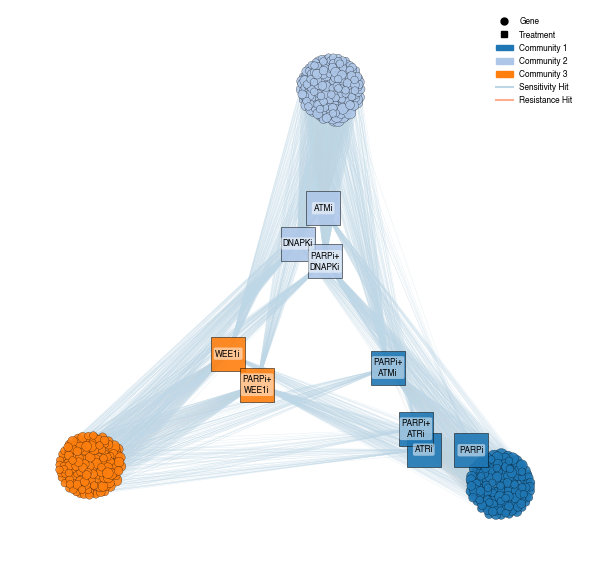

In [431]:
%matplotlib inline
gr_sen_comm_nx = plot_community_network(
    gr_sen_comm, gr_sen_clustered,
    # output_file='gene_communities_sen_nx_final.pdf', 
    figsize=(6, 6)
)

In [436]:
all_enriched = pathway_enrichment_for_communities(gr_sen_comm, database="GO_Biological_Process_2025")

01:03:35 - INFO - Performing Enrichr analysis using database GO_Biological_Process_2025.
01:03:35 - INFO - Performing Enrichr analysis using database GO_Biological_Process_2025.
01:03:36 - INFO - Performing Enrichr analysis using database GO_Biological_Process_2025.


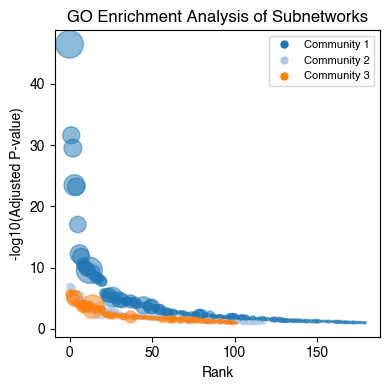

In [437]:
%matplotlib inline
plot_enrichment_results(
    all_enriched,
    # output_file='enrichment_results_sen.pdf',
    FDR_THRESHOLD=.1
)

In [440]:
# significant_results.to_csv('gene_communities_enrichment_results.csv', index_label='index')

---

In [180]:
# gr_res_comm, gr_res_clustered = prepare_community_network(gr_res)

In [181]:
# gr_sen_comm_nx = plot_community_network(
#     gr_res_comm, gr_res_clustered,
#     output_file='gene_communities_res_nx_final.pdf', 
#     figsize=(5, 5)
# )

---

#### interactive visualization


- https://docs.bokeh.org/en/2.4.3/docs/user_guide/graph.html

In [441]:
# # Write NetworkX graph to file for openning in Cytoscape
# nx.write_graphml(gr_all_comm_nx, 'gene_communities_network.graphml')

In [ ]:
# cyto = ig.drawing.graph.CytoscapeGraphDrawer()

# cyto.draw(graph=gr)

In [ ]:
# from pyvis.network import Network

# nt = Network('500px', '500px',notebook=True)
# nt.from_nx(gr_plot.to_networkx())
# nt.show('test.html')

#### Integrate with PrimeKG with DDRi screen data


https://github.com/mims-harvard/TDC?tab=readme-ov-file#tutorials


In [ ]:
# primekg_plus_DDRi_screens_A549_CRISPRi_kg = KnowledgeGraph(
#     df = pd.concat([
#         DDRi_screens_A549_CRISPRi_kg.df.drop(columns=['score']).copy(), 
#         primekg.df]
#     )
# )

# primekg_plus_DDRi_screens_A549_CRISPRi_kg.df['x_id'] = primekg_plus_DDRi_screens_A549_CRISPRi_kg.df['x_name']
# primekg_plus_DDRi_screens_A549_CRISPRi_kg.df['y_id'] = primekg_plus_DDRi_screens_A549_CRISPRi_kg.df['y_name']

---

In [ ]:
# # Example function to find repositioning opportunities for a given drug-gene node
# def find_repositioning_opportunities(kg, node):
    
#     G = nx.from_pandas_edgelist(kg.df, 'x_id', 'y_id', edge_attr='relation', edge_key=kg.df.index)
    
#     neighbors = list(G.neighbors(node))
#     edges = [G[node][neighbor]['key'] for neighbor in neighbors]
    
#     return edges 

In [ ]:
# find_repositioning_opportunities(
#     primekg_plus_DDRi_screens_A549_CRISPRi_kg,
#     'PRDX1'
# )

In [ ]:
# # Find repositioning opportunities for a specific drug
# drug_name = 'PRDX1'

# repositioning_opportunities = find_repositioning_opportunities(primekg_plus_DDRi_screens_A549_CRISPRi_nx, drug_name)

# repositioning_opportunities

### betweenness analysis

In [ ]:
def plot_betweenness(g, ax, cax1, cax2, d_thr = 9):
    '''Plot vertex/edge betweenness, with colorbars

    Args:
        g: the graph to plot.
        ax: the Axes for the graph
        cax1: the Axes for the vertex betweenness colorbar
        cax2: the Axes for the edge betweenness colorbar
    '''
    vertex_betweenness = g.betweenness()
    edge_betweenness = g.edge_betweenness()

    # Rescale betweenness to be between 0.0 and 1.0
    scaled_vertex_betweenness = ig.rescale(vertex_betweenness, clamp=True)
    scaled_edge_betweenness = ig.rescale(edge_betweenness, clamp=True)
    print(f"vertices: {min(vertex_betweenness)} - {max(vertex_betweenness)}")
    print(f"edges: {min(edge_betweenness)} - {max(edge_betweenness)}")

    # Define mappings betweenness -> color
    cmap1 = LinearSegmentedColormap.from_list("vertex_cmap", ["pink", "indigo"])
    cmap2 = LinearSegmentedColormap.from_list("edge_cmap", ["lightblue", "midnightblue"])

    # Plot graph
    g.vs["color"] = [cmap1(betweenness) for betweenness in scaled_vertex_betweenness]

    g.vs["frame_color"] = [
        'red' if d >= d_thr and nType != 'drug' else 'black' for d,nType in zip(g.vs.degree(),g.vs['type'])
    ]
    
    # frame_colors = []
    # for d,name,nType in zip(g.vs.degree(),g.vs['name'], g.vs['nodeType']):
    #     if d >= d_thr and nType != 'drug':
    #         frame_colors.append('red')
    #     elif d < d_thr and nType != 'drug':
    #         frame_colors.append('black')
    #     elif '+' in name and nType == 'drug':
    #         frame_colors.append('green')
    #     else:
    #         frame_colors.append('blue')
            
    # g.vs["frame_color"] = frame_colors
    
    
    g.vs["frame_width"] = [
        3 if d >= d_thr and nType != 'drug' else 1 for d,nType in zip(g.vs.degree(),g.vs['type'])
    ]
    
    s_scale = 2
    g.vs["size"]  = [20 * s_scale if d > 10 else d * s_scale for d in g.vs.degree()]
    g.vs['shape'] = ['rectangle' if nType is 'drug' else 'circle' for nType in g.vs['type']]
    g.vs['label'] = [name if d > 10 else '' for d,name in zip(g.vs.degree(), g.vs['name'])]

    g.es["size"] = [betweenness for betweenness in scaled_edge_betweenness]
    g.es["color"] = [cmap2(betweenness) for betweenness in scaled_edge_betweenness]
    g.es["width"] = ig.rescale(edge_betweenness, (0.5, 1.0))

    # g.layout_fruchterman_reingold(niter=10000)
    # g.layout_reingold_tilford_circular(mode='in')
    
    ig.plot(
        g,
        target=ax,
        layout="fruchterman_reingold",
        keep_aspect_ratio=True,
    )

    # Color bars
    norm1 = ScalarMappable(norm=Normalize(0, max(vertex_betweenness)), cmap=cmap1)
    norm2 = ScalarMappable(norm=Normalize(0, max(edge_betweenness)), cmap=cmap2)
    plt.colorbar(norm1, cax=cax1, orientation="horizontal", label='Vertex Betweenness')
    plt.colorbar(norm2, cax=cax2, orientation="horizontal", label='Edge Betweenness')
    
    return g

---

vertices: 0.0 - 1146886.2590298038
edges: 793.6828160272443 - 4341.864417933612


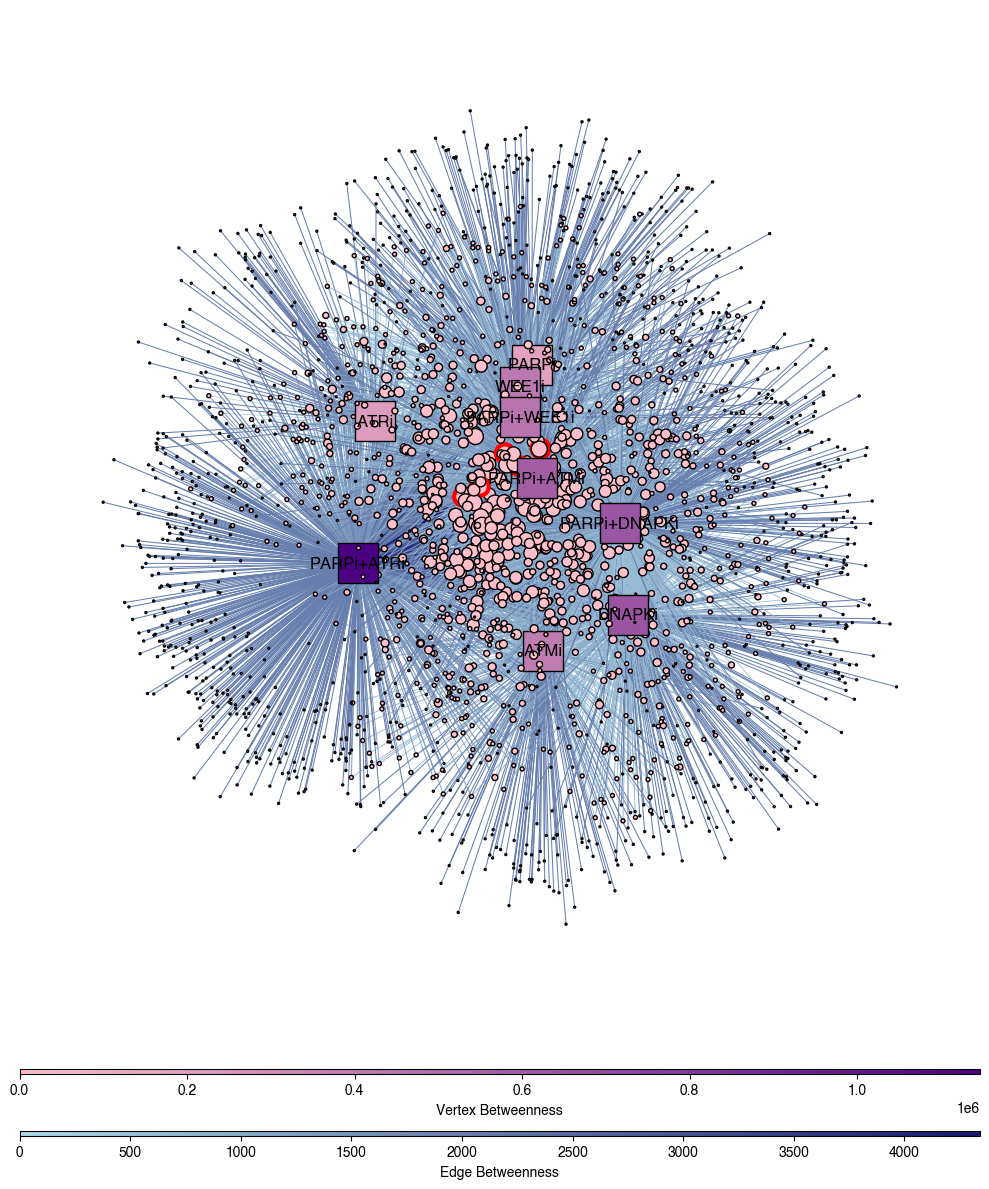

In [443]:
%matplotlib inline 
fig, axs = plt.subplots(
    3, 1,
    figsize=(10, 12),
    gridspec_kw={"height_ratios": (20, .1, .1)}
)

gr_plot = plot_betweenness(gr_all, *axs)

fig.tight_layout(h_pad=1)
# plt.savefig("Fig-2C.pdf")
plt.show()


vertices: 0.0 - 394999.1538420633
edges: 366.4092072072435 - 2391.3153210756623


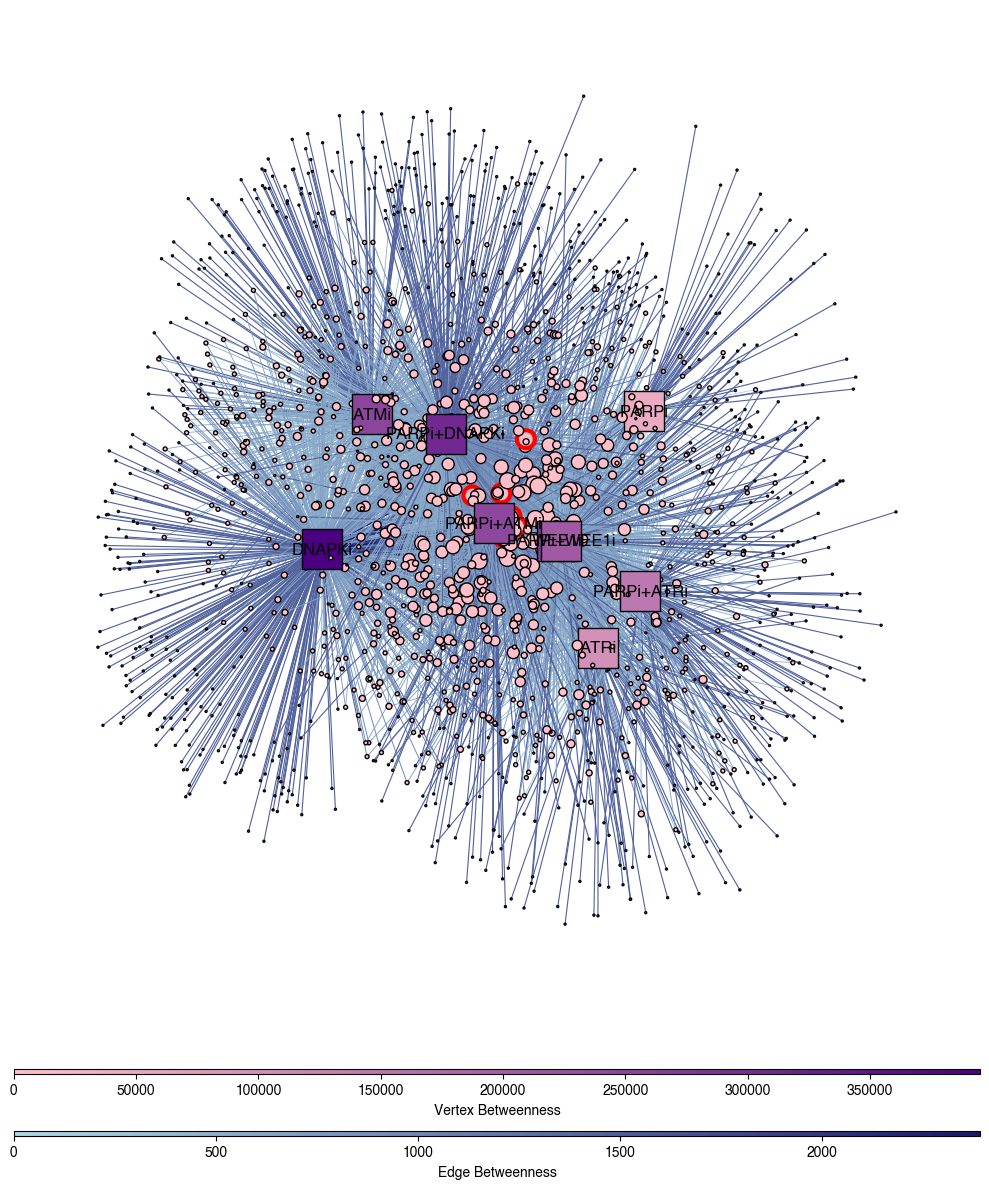

In [444]:
%matplotlib inline 
fig, axs = plt.subplots(
    3, 1,
    figsize=(10, 12),
    gridspec_kw={"height_ratios": (20, .1, .1)}
)

gr_plot = plot_betweenness(gr_sen, *axs)

fig.tight_layout(h_pad=1)
# plt.savefig("Fig-2C.pdf")
plt.show()


### Annotated graph to highlight PRDX1
<!-- - color `edge` by rho score direction 
- weight`edge` by rho score values
- circle gene `nodes` and square treatment nodes
- size gene `nodes` give a confidence value from the p-values
    - maybe average of `-log10(p-values)`
    - https://stats.stackexchange.com/questions/78596/when-combining-p-values-why-not-just-averaging
- export data for cytoscape visualization -->

In [447]:
[n for d,n in zip(gr_sen.degree(),gr_sen.vs['name']) if d >= 9 and 'i' not in n]

['CDK12', 'MCPH1', 'PRDX1', 'RAD9A', 'RFC5', 'XRCC3']

In [ ]:
# gr = gr.simplify()

vertices: 2.1595457480356046 - 33196.923435099416
edges: 23.81999624334704 - 350.54016538559654


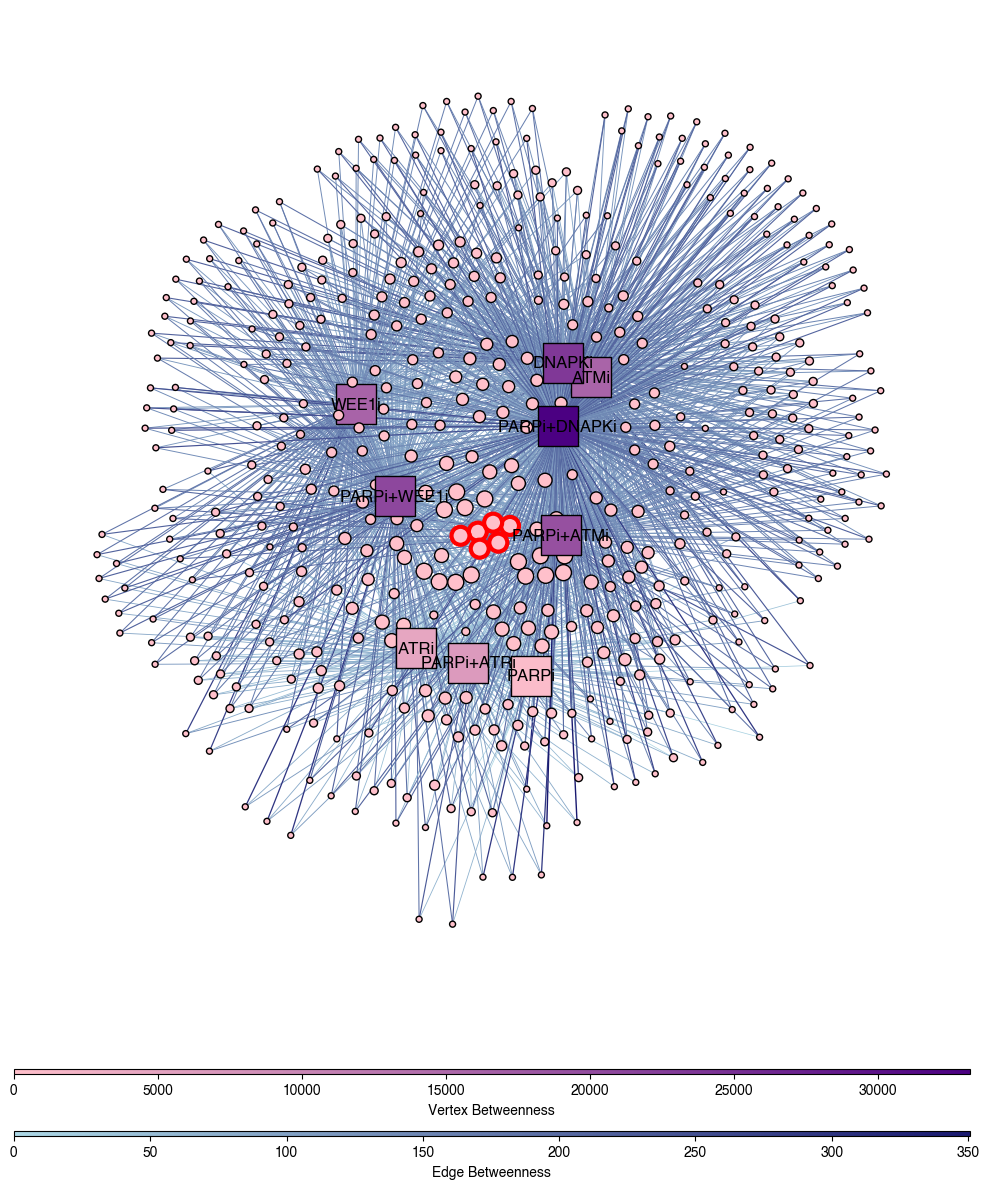

In [449]:
%matplotlib inline 
fig, axs = plt.subplots(
    3, 1,
    figsize=(10, 12),
    gridspec_kw={"height_ratios": (20, .1, .1)}
)

gr_plot = plot_betweenness(filter_graph_by_degree(gr_sen), *axs)

fig.tight_layout(h_pad=1)
# plt.savefig("Fig-2C.pdf")
plt.show()


# 

In [450]:
from watermark import watermark
print(
    watermark()
)

Last updated: 2025-08-05T01:08:13.746983-07:00

Python implementation: CPython
Python version       : 3.12.0
IPython version      : 9.4.0

Compiler    : GCC 12.3.0
OS          : Linux
Release     : 5.15.0-131-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 56
Architecture: 64bit



In [451]:
print(
    watermark(iversions=True, globals_=globals())
)

matplotlib: 3.10.3
igraph    : 0.11.9
gget      : 0.29.2
networkx  : 3.5
anndata   : 0.12.1
screenpro : 0.5.1
numpy     : 1.26.4
pandas    : 2.3.1
watermark : 2.5.0



___